In [318]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    confusion_matrix, roc_curve, 
    precision_recall_fscore_support, plot_roc_curve, roc_auc_score
)

import plotly.express as px

In [319]:
data_dir = '../../data'

In [320]:
df_reg = pd.read_csv(os.path.join(data_dir, 'model/full.csv'))
train = pd.read_csv(os.path.join(data_dir, 'model/train.csv'))
val = pd.read_csv(os.path.join(data_dir, 'model/validate.csv'))
test = pd.read_csv(os.path.join(data_dir, 'model/test.csv'))

train_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in train['id']]
val_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in val['id']]
test_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in test['id']]

# Transactions 

In [321]:
fname = '../../data/main/savingacct_txn.csv'
col_date = 'D_TRANSACTION_DATE'
col_amt = 'D_TRAN_AMOUNT'
col_mult = 'D_TRAN_TYPE'

In [322]:
# reading and basic preprocessing
df_trans = pd.read_csv(fname)
df_trans = df_trans[df_trans['id'].isin(df_reg['id'])]

df_trans['date'] = pd.to_datetime(df_trans[col_date])
df_trans['transact_d'] = df_trans['transact_c'] = df_trans[col_amt]
df_trans.loc[df_trans[col_mult] == 'C', 'transact_d'] = 0
df_trans.loc[df_trans[col_mult] == 'D', 'transact_c'] = 0
df_trans = df_trans[['id', 'date', 'transact_c', 'transact_d']]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:

Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.



In [323]:
# summarise sum by id and day
df_fillers = pd.DataFrame({
    'id': np.tile(df_reg['id'], 365),
    'date': np.repeat(pd.date_range(start='1/1/2021', end='31/12/2021'), len(df_reg['id'])),
    'transact_c': 0, 
    'transact_d': 0
})
df_trans = df_trans.append(df_fillers)

df_trans['day'] = (pd.to_datetime(df_trans['date']) \
                    .apply(lambda x: x.value) - pd.to_datetime('1/1/2021').value) // 86400000000000

df_trans = df_trans.sort_values(['id', 'day'])
df_trans = df_trans.groupby(['id', 'day']).sum().reset_index(drop=False)
df_trans = df_trans.set_index('id')

### Feature extraction

In [324]:
# roll data by id
rolling_window = 14

dict_rolled = {}
for cid in tqdm(df_reg['id']):
    df = df_trans.loc[cid, ][['transact_c', 'transact_d']]
    df = df.rolling(window=rolling_window).apply(lambda x : sum(x) / rolling_window)
    df = df.dropna().reset_index(drop=True)
    dict_rolled[cid] = df

  0%|          | 0/5994 [00:00<?, ?it/s]

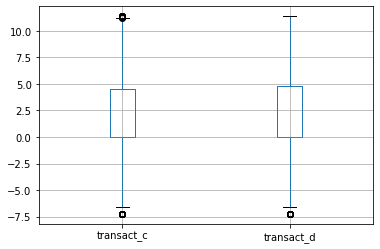

In [325]:
# combine rolled dfs to check dist, min, max
df_rolled_full = pd.concat(list(dict_rolled.values()))
df_rolled_full = np.log(df_rolled_full.replace({0: 1}))
_ = df_rolled_full.boxplot()

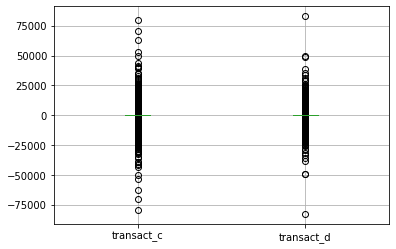

In [326]:
# rolled diff
df_rolled_diff = pd.concat(list(dict_rolled.values()))
df_rolled_diff = df_rolled_diff.diff(1)
_ = df_rolled_diff.boxplot()

In [402]:
def log_transform(array):
    return np.log(array.replace({0: 1}))

def transacts_to_bins(transacts, bins, log=False):
    if log:
        transacts = log_transform(transacts)
    feat = np.zeros((len(bins)))
    tmp = np.digitize(transacts, bins) - 1
    tmp = pd.DataFrame(tmp).reset_index(drop=False).groupby(0).count()['index']
    feat[tmp.index] = tmp
    return feat

def get_diff(transacts):
    transacts = transacts.diff(1).dropna()
    transacts = transacts[transacts != 0]
    return transacts

def get_features(df, bins):
    feat_c = transacts_to_bins(df['transact_c'], bins['transact_c'], log=True)
    feat_d = transacts_to_bins(df['transact_d'], bins['transact_d'], log=True)
#     feat_c_diff = transacts_to_bins(get_diff(df['transact_c']), bins['transact_c_diff'])
#     feat_d_diff = transacts_to_bins(get_diff(df['transact_c']), bins['transact_d_diff'])
    
    meta = [('transact_c', len(feat_c)), ('transact_d', len(feat_d))]
#     return np.concatenate([feat_c, feat_d, feat_c_diff, feat_d_diff]), meta
#     return np.concatenate([feat_c_diff, feat_d_diff]), meta
    return np.concatenate([feat_c, feat_d]), meta
        

Main feature extraction

In [397]:
nbins = 59
bins = {
    'transact_c': np.linspace(
        df_rolled_full['transact_c'].min(), 
        df_rolled_full['transact_c'].max(), 
        nbins
    ),
    'transact_d': np.linspace(
        df_rolled_full['transact_d'].min(), 
        df_rolled_full['transact_d'].max(), 
        nbins
    ),
#     'transact_c_diff': np.linspace(
#         df_rolled_diff['transact_c'].min(), 
#         df_rolled_diff['transact_c'].max(), 
#         nbins
#     ),
#     'transact_d_diff': np.linspace(
#         df_rolled_diff['transact_d'].min(), 
#         df_rolled_diff['transact_d'].max(), 
#         nbins
#     )
}

X = np.zeros((len(df_reg), sum([len(bins[x]) for x in bins])))
for i, cid in tqdm(enumerate(df_reg['id'])):
    feat, meta = get_features(dict_rolled[cid], bins)
    X[i, :] = feat

# # remove features with all 0s
# X = X[:, X.sum(axis=0) != 0]
# X.shape

Visualisation

In [403]:
nbins = 30
bins = {
    'transact_c': np.linspace(
        df_rolled_full['transact_c'].min(), 
        df_rolled_full['transact_c'].max(), 
        nbins
    ),
    'transact_d': np.linspace(
        df_rolled_full['transact_d'].min(), 
        df_rolled_full['transact_d'].max(), 
        nbins
    ),
#     'transact_c_diff': np.linspace(
#         df_rolled_diff['transact_c'].min(), 
#         df_rolled_diff['transact_c'].max(), 
#         nbins
#     ),
#     'transact_d_diff': np.linspace(
#         df_rolled_diff['transact_d'].min(), 
#         df_rolled_diff['transact_d'].max(), 
#         nbins
#     )
}
X = np.zeros((len(df_reg), sum([len(bins[x]) for x in bins])))
for i, cid in tqdm(enumerate(df_reg['id'])):
    feat, meta = get_features(dict_rolled[cid], bins)
    X[i, :] = feat
    
colnames = []
for col, n in meta:
    for i in range(n):
        colnames.append(col + str(i))

0it [00:00, ?it/s]

In [406]:
col = 'transact_d'

df_X = pd.DataFrame(X)
df_X.columns = colnames
df_X['y'] = y
df_X = df_X.melt('y', colnames, var_name=col)
df_X[col] = df_X[col].str.extract('([0-9]+)').astype(int)

In [408]:
df_X_avg = df_X[['y', col, 'value']].groupby(['y', col]).mean()
df_X_avg = df_X_avg.reset_index(drop=False)
tmp = np.exp(bins[col])
df_X_avg['amount'] = df_X_avg[col].map(dict(zip(range(len(tmp)), tmp)))
df_X_avg.loc[df_X_avg['amount'] <= 1, 'value'] = 0


fig = px.line(df_X_avg, x="amount", y="value", color='y', line_shape='spline')
fig.show()

Param tuning

In [110]:
y = df_reg['is_affluent_cur']
    
for nbins in tqdm([55, 56, 57, 58, 59, 60]):

    bins = {
        'transact_c': np.linspace(
            df_rolled_full['transact_c'].min(), 
            df_rolled_full['transact_c'].max(), 
            nbins
        ),
        'transact_d': np.linspace(
            df_rolled_full['transact_d'].min(), 
            df_rolled_full['transact_d'].max(), 
            nbins
        ),
    }

    X = np.zeros((len(df_reg), sum([len(bins[x]) for x in bins])))
    for i, cid in (enumerate(df_reg['id'])):
        X[i, :] = get_features(dict_rolled[cid], bins)

    # remove features with all 0s
    X = X[:, X.sum(axis=0) != 0]

    X_train, y_train = split_by_idxs(X, y, train_idxs)
    X_val, y_val = split_by_idxs(X, y, val_idxs)
    X_test, y_test = split_by_idxs(X, y, test_idxs)
    
    svm = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
    svm.fit(X_train, y_train)
    pred_probs = svm.predict_proba(X_val)
    acc = round(roc_auc_score(y_val, pred_probs[:, 1]), 2)
    print(nbins, acc)

  0%|          | 0/6 [00:00<?, ?it/s]

55 0.65
56 0.64
57 0.63
58 0.64
59 0.68
60 0.66


```
10 0.57
20 0.57
30 0.61
40 0.65
50 0.64
55 0.65
56 0.64
57 0.63
58 0.64
59 0.68
60 0.66
70 0.65
80 0.63
90 0.65
100 0.66
```

### Modelling (SVM)

In [329]:
# get train test val X, y

def split_by_idxs(X, y, idxs):
    return X[idxs, :], np.array(y)[idxs]

y = df_reg['is_affluent_cur']

X_train, y_train = split_by_idxs(X, y, train_idxs)
X_val, y_val = split_by_idxs(X, y, val_idxs)
X_test, y_test = split_by_idxs(X, y, test_idxs)

In [330]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
svm.fit(X_train, y_train)
pred_probs = svm.predict_proba(X_val)
roc_auc_score(y_val, pred_probs[:, 1])

0.6706274755055243

In [49]:
pred = (pred_probs[:, 0] < 0.96).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(y_val, pred, average='weighted')
print(np.array([precision, recall, f1]).round(4))
confusion_matrix(pred, y_val)

[0.9383 0.5222 0.6483]


array([[441,  10],
       [420,  29]])

0.6566604127579738

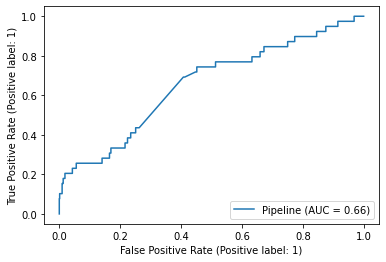

In [50]:
plot_roc_curve(svm, X_val, y_val)
roc_auc_score(y_val, pred_probs[:, 1])